In [1]:
%matplotlib inline

In [2]:
from phd import *

In [3]:
#data = np.load(datapath("braindrop-delay-network-1544200039.2997181.npz"))
data = np.load(datapath("delay_network_1538398994.3587925.npz"))
list(data.keys())

['t', 'u', 'x_hat', 'x', 'C']

In [4]:
# The file from the original PIEEE npz file had `x` instead of `x_ideal`
x_ideal = data['x']

In [5]:
def set_style():
    # Adapted from dn.py::set_style
    plt.style.use(datapath('ieee_tran.mplstyle'))

    SMALL_SIZE = 16
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 30

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rc('text', usetex=True)

set_style()

/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif', 'monospace', 'sans\\-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif', 'monospace', 'sans\\-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


['/tmp/delay-network-_0utamw0.png', '/tmp/delay-network-bchr5ekp.png', '/tmp/delay-network-7c4fszmz.png', '/tmp/delay-network-mblhv3h1.png', '/tmp/delay-network-xvjjxxi7.png', '/tmp/delay-network-kzimrwt_.png', '/tmp/delay-network-qq8uyduj.png', '/tmp/delay-network-f9xwow7y.png', '/tmp/delay-network-j2lh4flc.png', '/tmp/delay-network-90hfkewa.png', '/tmp/delay-network-sbo9b37g.png', '/tmp/delay-network-my4atdsy.png', '/tmp/delay-network-f6s9aciv.png', '/tmp/delay-network-v2qm1i_i.png', '/tmp/delay-network-z8ymi2pu.png', '/tmp/delay-network-d38r62xh.png', '/tmp/delay-network-oyrfj2nx.png', '/tmp/delay-network-6m1u83fr.png', '/tmp/delay-network-n2b5hhxe.png', '/tmp/delay-network-t9gdnmj5.png', '/tmp/delay-network-_dla9uve.png', '/tmp/delay-network-fqk2e362.png', '/tmp/delay-network-hqv6tpgi.png', '/tmp/delay-network-tasm1e12.png']


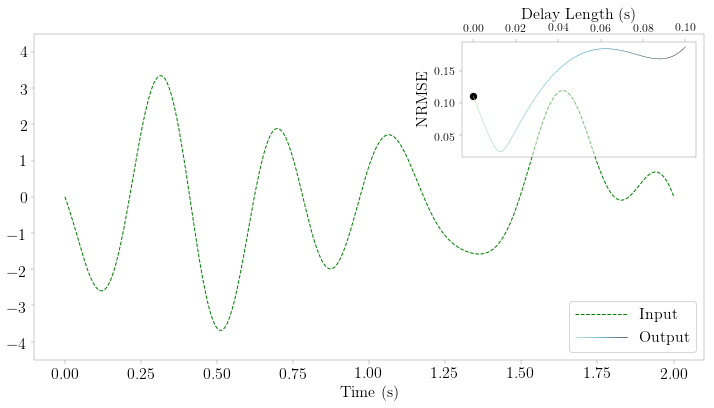

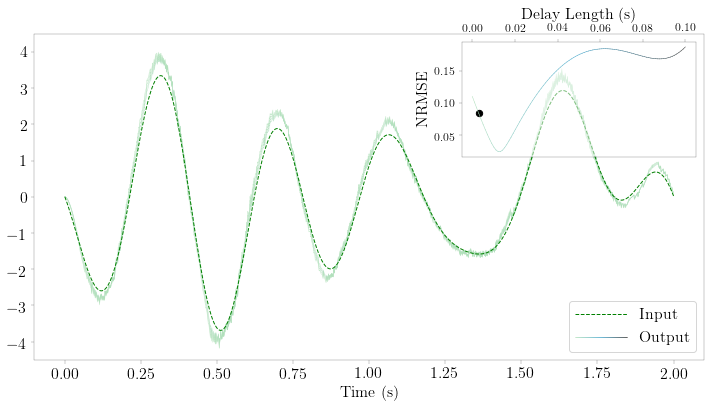

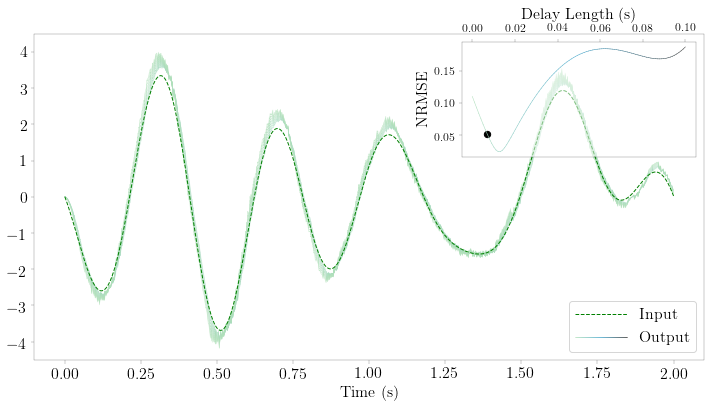

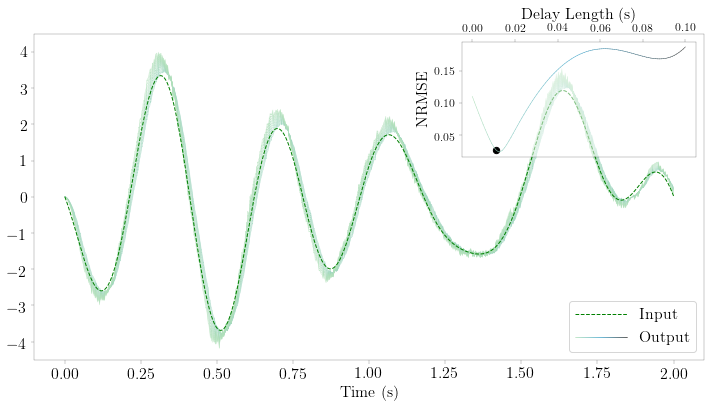

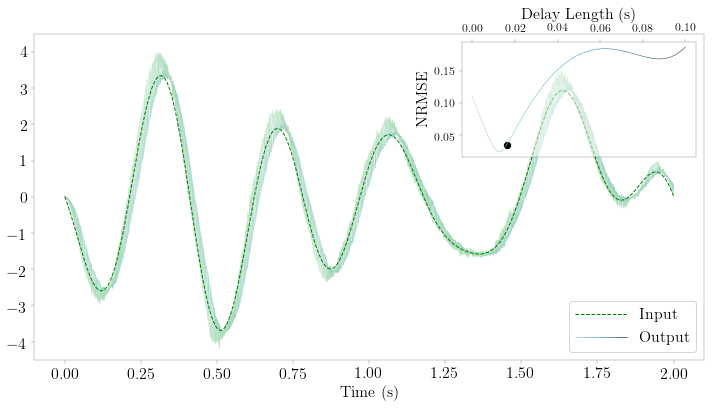

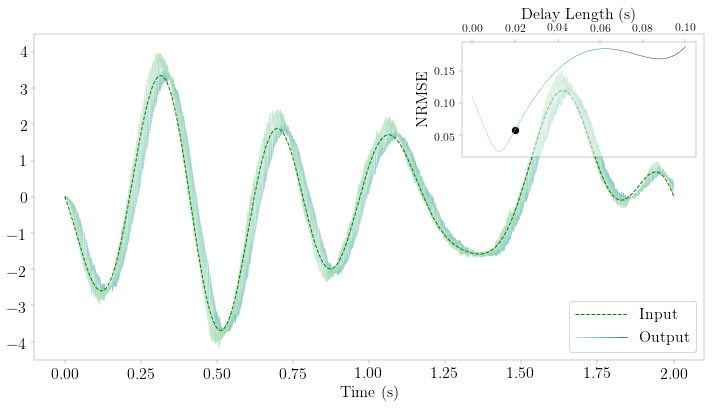

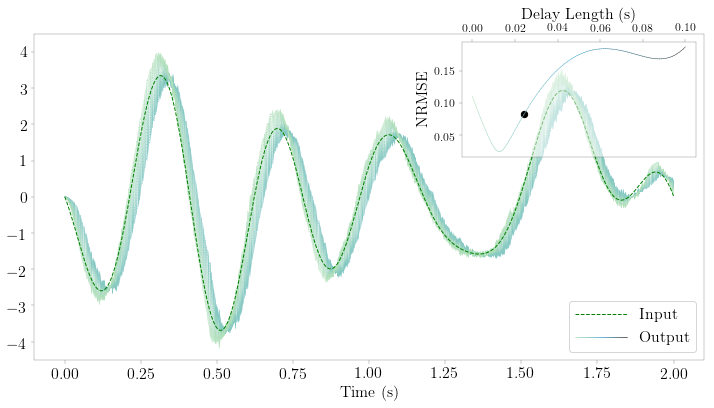

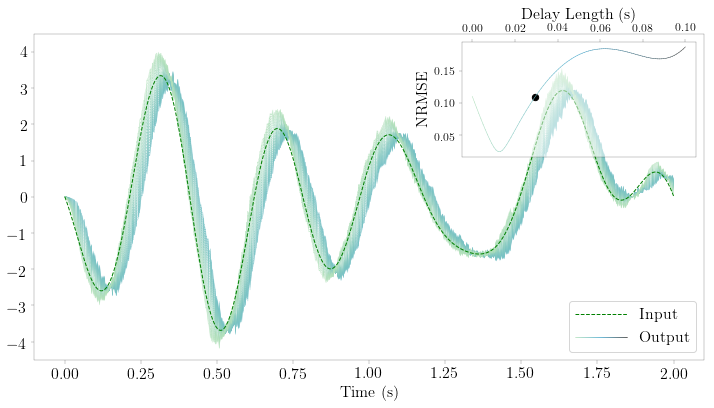

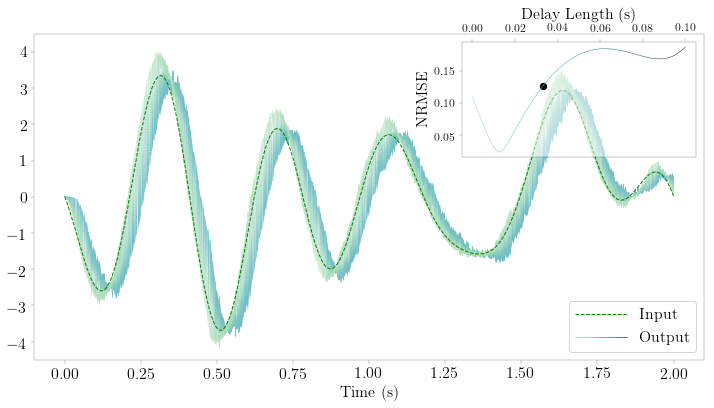

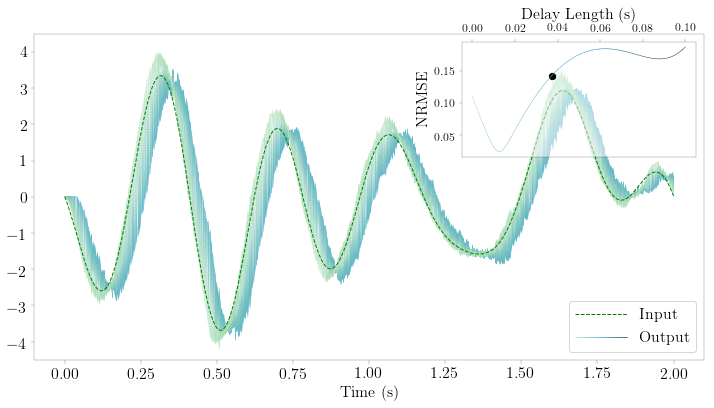

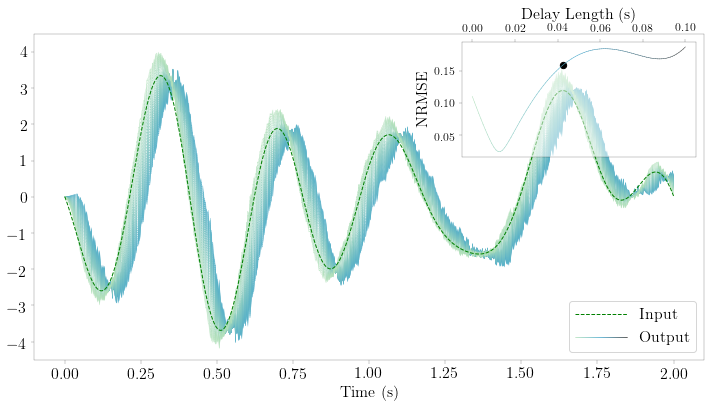

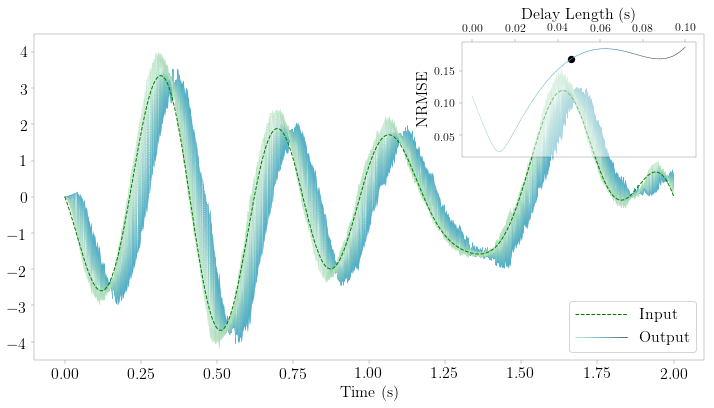

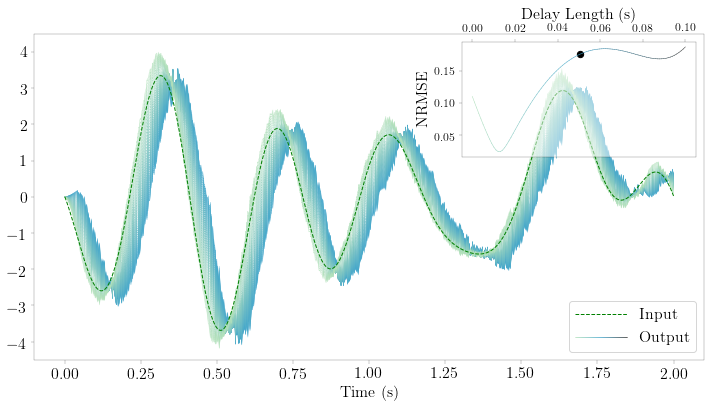

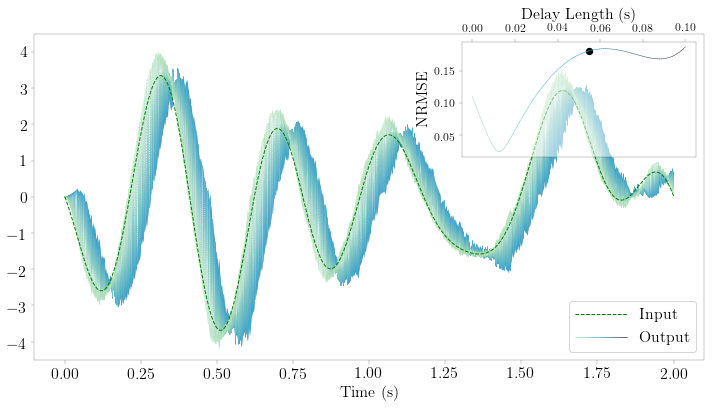

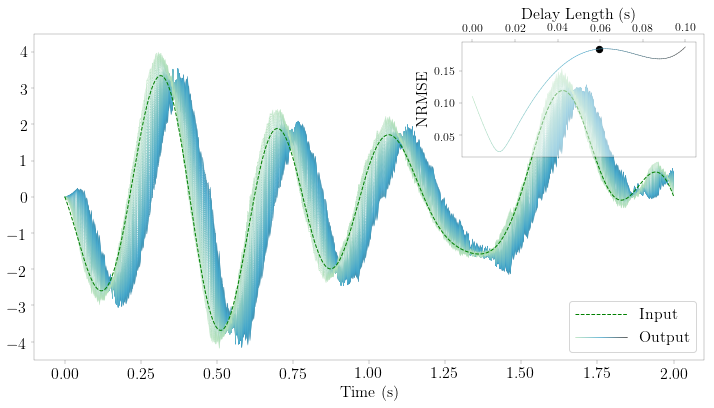

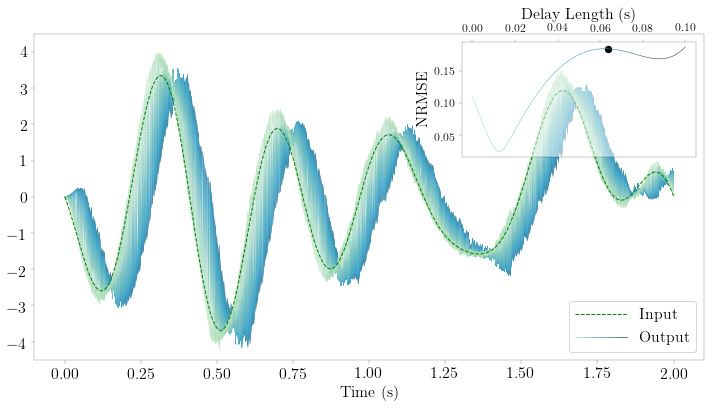

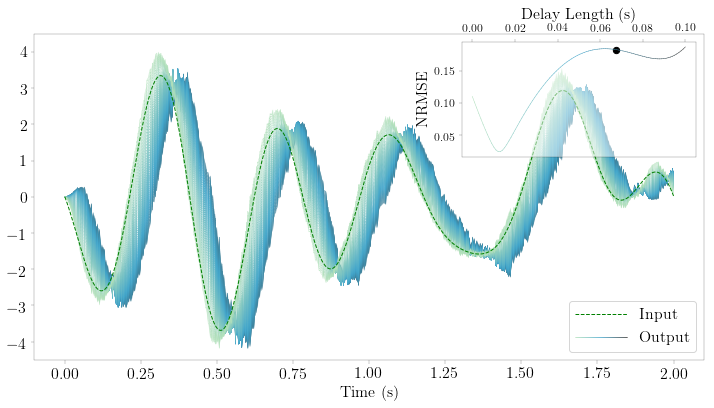

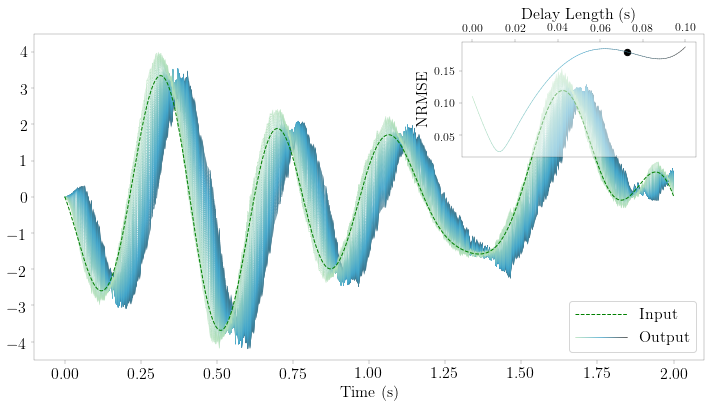

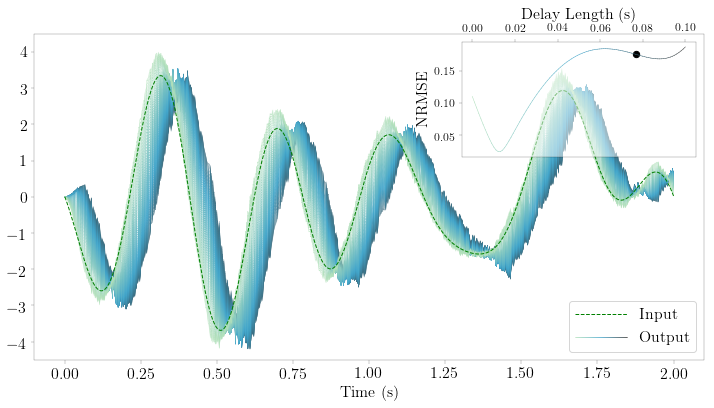

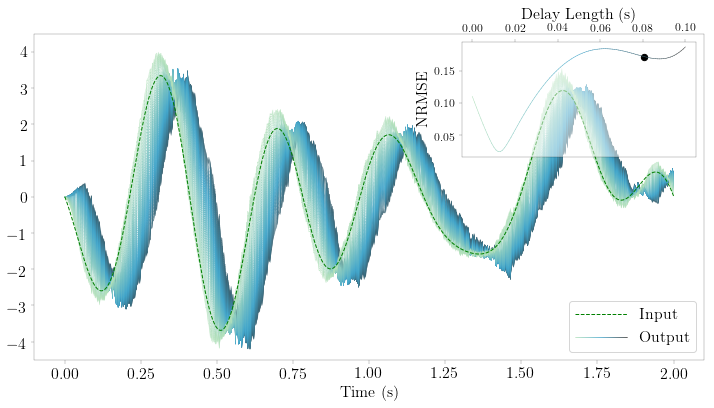

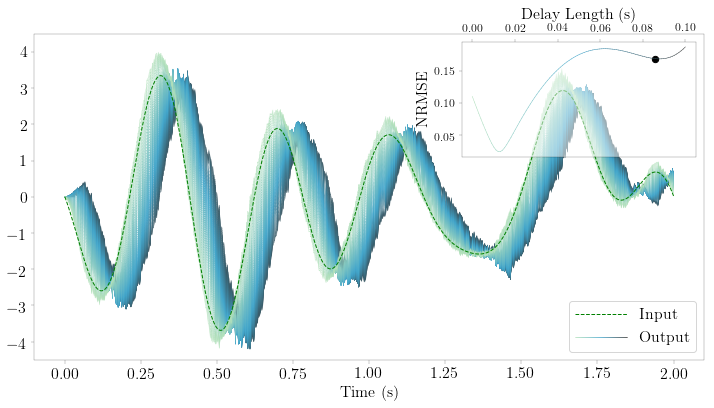

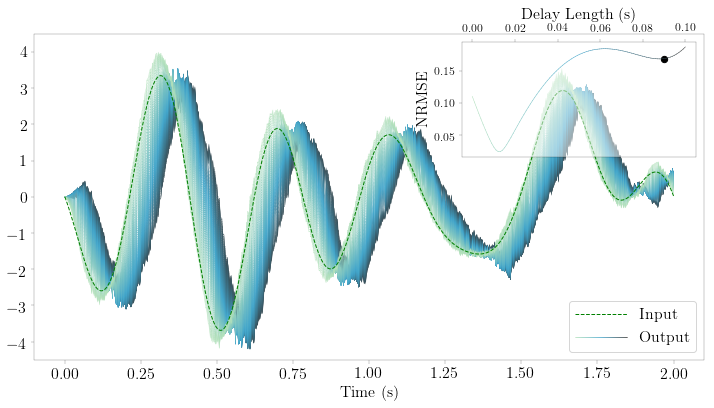

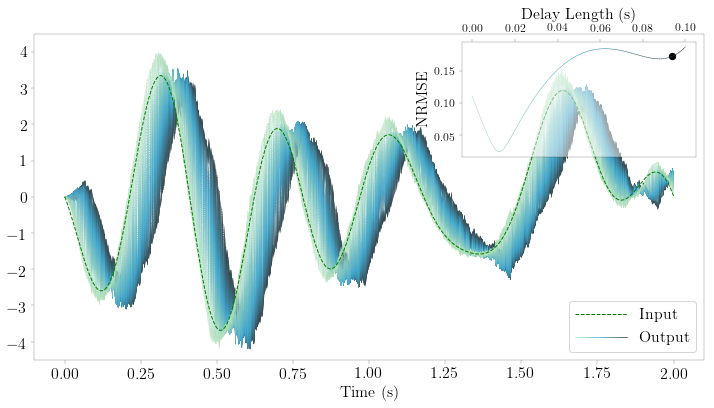

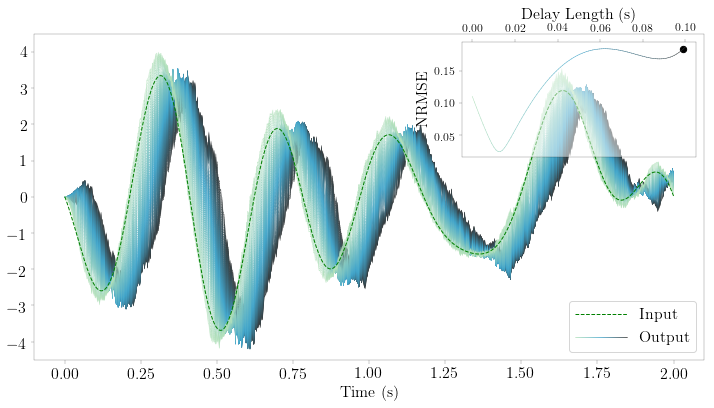

In [6]:
import imageio
from tempfile import NamedTemporaryFile

from nengolib.signal import nrmse
from utils import HandlerDashedLines, LineCollection

theta = 0.1
x_hat = data['x_hat']
#x_ideal = data['x_ideal']
C = data['C']
u = data['u']
t = data['t']
w = C.dot(x_hat.T)
w_ideal = C.dot(x_ideal.T)
t_samples, order = C.shape
top_cmap = sns.color_palette('GnBu_d', t_samples)[::-1]
n_frames = t_samples

def go(frame, dpi=100):
    # Adapted from dn.py::analyze
    filename = NamedTemporaryFile(
        suffix=".png", prefix="delay-network-", delete=False).name
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
    ax = [ax]
    for c, w_i in list(zip(top_cmap, w))[:frame][::-1]:
        ax[0].plot(t, w_i, c=c, alpha=0.7)
    target_line, = ax[0].plot(t, u, c='green', linestyle='--', lw=1)
    ax[0].set_ylim(np.min(w), np.max(w) + 1)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    insert = inset_axes(ax[0], width="35%", height=1.6, loc='upper right')
    insert.patch.set_alpha(0.5)
    insert.xaxis.tick_top()
    insert.tick_params(axis='x', labelsize=12)
    insert.tick_params(axis='y', labelsize=12)
    insert.xaxis.set_label_position('top') 
    t_window = np.linspace(0, theta, t_samples)
    e_window = nrmse(w, target=w_ideal, axis=1)
    for i in range(1, t_samples):
        insert.plot([t_window[i-1], t_window[i]],
                    [e_window[i-1], e_window[i]],
                    c=top_cmap[i])
    if frame == 0:
        insert.scatter([t_window[0]], [e_window[0]], s=40)
    else:
        insert.scatter([t_window[frame-1]], [e_window[frame-1]], s=40)
    insert.set_xlabel("Delay Length (s)")
    insert.set_ylabel("NRMSE")
    #insert.set_ylim(0, max(e_window))
    #ax[0].set_title("Delay Network")
    ax[-1].set_xlabel("Time (s)")

    ax[0].set_ylim(-4.5, 4.5)  # hack to not let this jump around between frames

    top_lc = LineCollection(
        len(C) * [[(0, 0)]], lw=1, colors=top_cmap)
    ax[0].legend([target_line, top_lc], ["Input", "Output"],
                 handlelength=3.2, loc='lower right',
                 handler_map={LineCollection: HandlerDashedLines()})

    fig.savefig(filename, bbox_inches='tight', dpi=dpi)
    
    return filename

filenames = []
for frame in np.linspace(0, n_frames-1, 24, dtype=int):
    filenames.append(go(frame))
print(filenames)

In [7]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('delay-network.gif', images)